In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
path = "C:/Users/shrra/Downloads/2024-06-25T13-17_export.csv"
datafram =pd.read_csv(path)

C:\Users\shrra\AppData\Local\Temp\ipykernel_22404\238935856.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_counts.index, y=race_counts.values, palette='viridis')


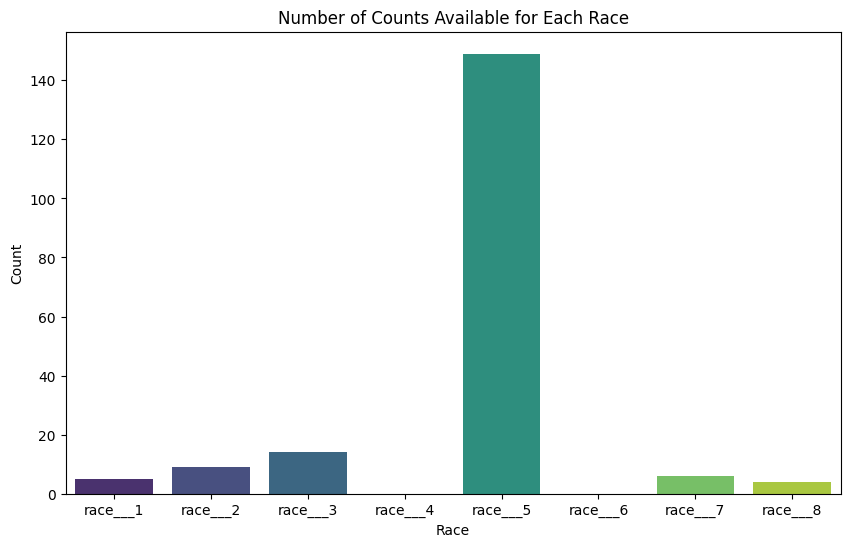

In [11]:

race_columns = ['race___1', 'race___2', 'race___3', 'race___4', 'race___5','race___6', 'race___7','race___8']  


race_counts = datafram[race_columns].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=race_counts.index, y=race_counts.values, palette='viridis')
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Number of Counts Available for Each Race')
plt.show()


In [4]:

df = pd.read_csv('C:/Users/shrra/Downloads/2024-06-25T13-17_export.csv')


selected_columns = ['record_id', 'demographics_session_id', 'race___5']
df = df[selected_columns]


df['subject_id'] = 'sub-' + df['record_id'] + '/ses-' + df['demographics_session_id']


train_ids, test_ids = train_test_split(df['subject_id'], test_size=0.2, random_state=42)
train_ids, val_ids = train_test_split(train_ids, test_size=0.2, random_state=42)
def get_file_paths(subject_ids, base_dir='D:/Bridge2AI/bridge2ai-voice-corpus-2-including-sensitive-recordings1/bids_with_sensitive_recordings/'):
    file_paths = []
    valid_ids = []
    for subject_id in subject_ids:
        session_dir = os.path.join(base_dir, subject_id, 'audio')
        found_file = False
        if os.path.exists(session_dir):
            for file_name in os.listdir(session_dir):
                if file_name.endswith('Rainbow-Passage_rec-Rainbow-Passage.wav'):
                    file_paths.append(os.path.join(session_dir, file_name))
                    valid_ids.append(subject_id)
                    found_file = True
                    break 
        if not found_file:
            print(f"Missing file for subject_id: {subject_id}")
    return file_paths, valid_ids

train_file_paths, train_valid_ids = get_file_paths(train_ids)
val_file_paths, val_valid_ids = get_file_paths(val_ids)
test_file_paths, test_valid_ids = get_file_paths(test_ids)

train_df = df[df['subject_id'].isin(train_valid_ids)]
val_df = df[df['subject_id'].isin(val_valid_ids)]
test_df = df[df['subject_id'].isin(test_valid_ids)]

print(f"Train file paths: {len(train_file_paths)}, Train labels: {len(train_df)}")
print(f"Validation file paths: {len(val_file_paths)}, Validation labels: {len(val_df)}")
print(f"Test file paths: {len(test_file_paths)}, Test labels: {len(test_df)}")


Missing file for subject_id: sub-a2044905-fcf0-4971-8567-7d5a772f431c/ses-685E523B-E78B-4F51-AB4B-F199B1269F8C
Missing file for subject_id: sub-ecc63817-d3f5-4766-893c-d47b8382e96d/ses-B5AC76B1-4B75-41DA-87BD-6ADCE7704A30
Missing file for subject_id: sub-6980ce82-b88d-4c5b-b6a6-8ed166dc9eb3/ses-0923200E-5774-40CF-AF67-4507AD1C650E
Missing file for subject_id: sub-f2f58f0a-4ffb-46b2-b95f-c4950ad82a83/ses-5A73EFCE-CD0B-4CB6-BFD2-976227E43C0C
Missing file for subject_id: sub-2e59cc45-df19-4e2d-a1d8-60c46cf47a63/ses-5E054A0F-CFA2-46AF-9248-14949EAB163E
Missing file for subject_id: sub-658d2539-03d3-4e43-b829-d6b6cf24a0b1/ses-54C5ABD6-208F-4D2A-B39F-D5EB23901024
Missing file for subject_id: sub-eed0e4a4-c915-4ada-9d23-9e0c56fa0d37/ses-BDC578CA-C29F-4736-B838-6E11462650D8
Missing file for subject_id: sub-ecf91a76-d72f-42e0-85e1-da9f2a7063f2/ses-347143D2-7D30-48B8-8C7F-218ABC49EC62
Train file paths: 108, Train labels: 108
Validation file paths: 28, Validation labels: 28
Test file paths: 35, T

In [5]:


def extract_features(file_paths, max_length=16000):
    features = []
    for file_path in file_paths:
        audio_binary = tf.io.read_file(file_path)
        audio, _ = tf.audio.decode_wav(audio_binary)
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.cast(audio, tf.float32)


        if tf.shape(audio)[0] > max_length:
            audio = audio[:max_length]
        else:
            zero_padding = tf.zeros([max_length] - tf.shape(audio), dtype=tf.float32)
            audio = tf.concat([audio, zero_padding], 0)

        features.append(audio.numpy())
    return np.array(features)

train_features = extract_features(train_file_paths)
val_features = extract_features(val_file_paths)
test_features = extract_features(test_file_paths)

print(f"Train features: {len(train_features)}, Train labels: {len(train_df)}")
print(f"Validation features: {len(val_features)}, Validation labels: {len(val_df)}")
print(f"Test features: {len(test_features)}, Test labels: {len(test_df)}")



Train features: 108, Train labels: 108
Validation features: 28, Validation labels: 28
Test features: 35, Test labels: 35


In [6]:
print(len(test_ids))

36


In [7]:

train_labels = train_df['race___5'].astype(int).values
val_labels = val_df['race___5'].astype(int).values
test_labels = test_df['race___5'].astype(int).values

train_features = train_features[..., np.newaxis]
val_features = val_features[..., np.newaxis]
test_features = test_features[..., np.newaxis]

print(f"Train features shape: {train_features.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation features shape: {val_features.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test features shape: {test_features.shape}, Test labels shape: {test_labels.shape}")

model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(16000, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_features, train_labels, epochs=20, batch_size=32, validation_data=(val_features, val_labels))


Train features shape: (108, 16000, 1), Train labels shape: (108,)
Validation features shape: (28, 16000, 1), Validation labels shape: (28,)
Test features shape: (35, 16000, 1), Test labels shape: (35,)
Epoch 1/20


c:\Users\shrra\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.6080 - loss: 0.6181 - val_accuracy: 0.7143 - val_loss: 0.6578
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.8668 - loss: 0.4012 - val_accuracy: 0.7143 - val_loss: 0.5623
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.8334 - loss: 0.4810 - val_accuracy: 0.7143 - val_loss: 0.6338
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8543 - loss: 0.4267 - val_accuracy: 0.7143 - val_loss: 0.6338
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8814 - loss: 0.3571 - val_accuracy: 0.7143 - val_loss: 0.5703
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8272 - loss: 0.4728 - val_accuracy: 0.7143 - val_loss: 0.6273
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.8366 - loss: 0.4424 - val_accuracy: 0.7143 - val_loss: 0.7001
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.8647 - loss: 0.3934 - val_accuracy: 0.7143 - val_loss: 0.6030
Epo

In [8]:

test_loss, test_accuracy = model.evaluate(test_features, test_labels)
print(f'Test Accuracy: {test_accuracy}')
model.save('voice_classification_cnn_model.h5')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8527 - loss: 0.7930


Test Accuracy: 0.8571428656578064


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8527 - loss: 0.7930
Test Accuracy: 0.8571428656578064


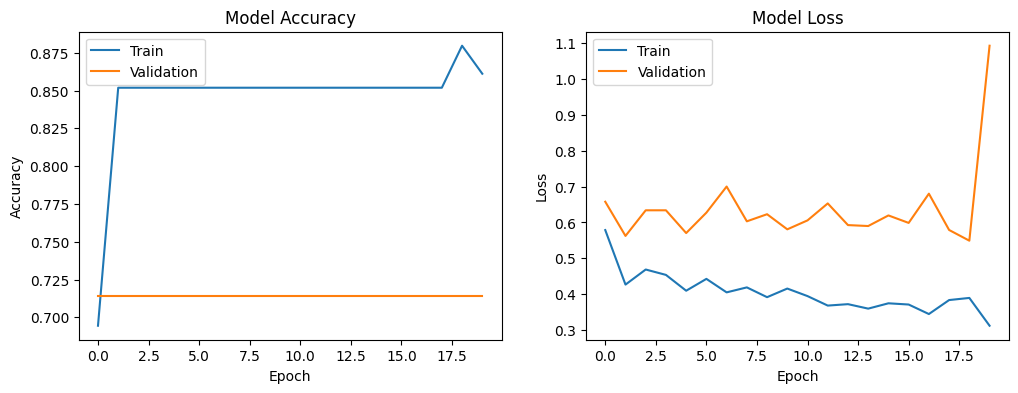

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


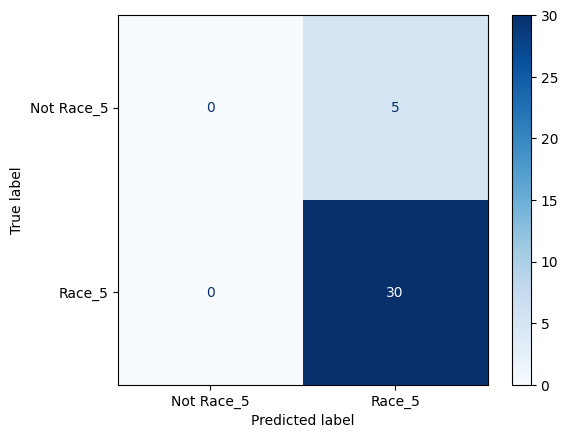

In [9]:
# Just for plotting

test_loss, test_accuracy = model.evaluate(test_features, test_labels)
print(f'Test Accuracy: {test_accuracy}')


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

test_predictions = (model.predict(test_features) > 0.5).astype("int32")

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Race_5', 'Race_5'])
disp.plot(cmap=plt.cm.Blues)
plt.show()
